# ***ezSegmenter***

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
#### * This segmentation tool enables creation of masks for objects not easily picked up by primary cell segmentation methods on multiplexed imaging data.
#### * In addition this tool can be used to create composites of channels as well as merge object masks with cell masks.
#### * Final Output : Image masks and cell+object tables.
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

In [1]:
import os
from ark.segmentation.ez_seg import (
    ez_object_segmentation,
    ez_seg_display,
    merge_masks,
    composites,
    ez_seg_utils,
)
from alpineer import io_utils
from ark.utils import example_dataset
from ark.segmentation import marker_quantification

## 0: Set root directory and (Optional) download example dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [2]:
# set up the base directory
base_dir = "../data/example_dataset"

If you would like to test the ez segmeneter features in Ark with an example dataset, run the cell below. Otherwise skip to section 1.

The cell below will download a dataset consisting of 10 FOVs with 47 channels, along with corresponding composite microglia images. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended leaving as `True` if you are doing a clean run of the `ark` pipeline using this dataset from the start. If you already have the dataset downloaded, set to `False`.

In [3]:
example_dataset.get_example_dataset(dataset="ez_seg_data", save_dir = base_dir, overwrite_existing = True)

# example data gets written to an ez_seg_data sub-folder
base_dir = os.path.join(base_dir, "ez_seg_data")

Found cached dataset ark_example (/Users/bryjc/.cache/huggingface/datasets/angelolab___ark_example/ez_seg_data/0.0.5/586e568564e0048c71fa3623c6ca77f2a244f4a7522ca9457bd9118d1ef32f76)


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/bryjc/Library/CloudStorage/GoogleDrive-bryjc@stanford.edu/My Drive/Software/ark-analysis/src/ark/utils/example_dataset.py:127: UserWarning: Files exist in ../data/example_dataset/ez_seg_data.                         They will be overwritten by the downloaded example dataset.
  warnings.warn(UserWarning(f"Files exist in {dst_path}. \


## 1: Set file paths & Get image paths

### Define directory paths

- `image_data_dir`: Channel data directory - MUST already exist.
- `subfolder_name`: If your image data is nested (e.g. ..fov0/rescaled/*) then replace None with the name of the dir (e.g. rescaled)
- `segmentation_dir`: Segmentation directory. Either not created yet or filled with cell masks - may already exist.
- `cell_table_dir`: Directory to store cell + object tables  - may already exist.
- `ez_visualization_dir`: Directory to store masks in a mantis viewer - friendly format - may already exist
- `composite_dir`: Directory to store composite images. Created by the notebook.
- `ez_masks_dir`: Sub-directory of segmentation directory that will store ez segmenter masks. Created by the notebook.
- `merged_masks_dir`: Directory to store merged cell + object masks. Created by the notebook.
- `log_dir`: Directory to store log info as .txt files. Created by the notebook.

In [4]:
image_data_dir = os.path.join(base_dir, "image_data")
sub_folder_name = None
segmentation_dir = os.path.join(base_dir, "segmentation")
cell_table_dir = os.path.join(base_dir, "cell_table")
ez_visualization_dir = os.path.join(base_dir, "mantis_visualization")

# automatically created by the notebook
composite_dir = os.path.join(base_dir, "composites")
ez_masks_dir = os.path.join(segmentation_dir, "ez_masks")
merged_masks_dir = os.path.join(segmentation_dir, "merged_masks_dir")
log_dir = os.path.join(base_dir, "logs")

In [5]:
# Create above directories if they do not exist
for directory in [
    segmentation_dir,
    cell_table_dir,
    ez_visualization_dir,
    composite_dir,
    ez_masks_dir,
    merged_masks_dir,
    log_dir
]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [6]:
# Validate paths of the directories.
io_utils.validate_paths(
    [
        image_data_dir,
        segmentation_dir,
        cell_table_dir,
        ez_visualization_dir,
        composite_dir,
        ez_masks_dir,
        merged_masks_dir,
        log_dir
    ]
)

### Compute and filter fov paths

FOV names should be stored as folders within the channel data directory as outlined earlier

In [7]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(image_data_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov0", "fov1"]

## 2. Composite Builder (Optional)

Here, you can combine channels to produce a single channel for later segmentation, through addition and / or subtraction of different channels.

#### Set composite values

- Set the name in `composite_name`, and channels to combine in `to_add` and `to_subtract`

Specify `image_type`:
   - "signal" = intensity or count based images.
   - "pixel_clustered" = individually labeled pixels by cluster label.

Specify `composite_method`:
   - "total" = return an image with summed values in each pixel.
   - "binary" = return an image with either filled (1) or empty (0) values in each pixel.

In [8]:
# What would you like to name your composite image
composite_name = "composite_microglia"

# What channels would you like to add together?
to_add = ["Iba1", "CD45"]
# What channels would you like to subtract?
to_subtract = ["HistoneH3Lyo", "Background"]

# What image type do you want returned?
image_type = "signal"
# What combination method do you want to use?
composite_method = "total"

#### Create your composite channel


In [9]:
# Run composite builder
composites.composite_builder(
    image_data_dir=image_data_dir,
    img_sub_folder = sub_folder_name,
    fov_list=fovs,
    images_to_add=to_add,
    images_to_subtract=to_subtract,
    image_type=image_type,
    composite_name=composite_name,
    composite_directory=composite_dir,
    composite_method=composite_method,
    log_dir=log_dir
)

Values saved to ../data/example_dataset/ez_seg_data/logs/composite_log.txt
Composites built and saved


#### View a composite test image
- `fov_name`: Specify which FoV you'd like to see for visual testing purposes.
- `composite_name`: This should be the composite name you specified above

In [13]:
fov_name = "fov0"
composite_name = "composite_microglia"

# Show test composite image
ez_seg_display.display_channel_image(composite_dir, sub_folder_name, fov_name, composite_name, composite=True)

KeyboardInterrupt: 

#### View a channel image
- `fov_name`: Specify which FoV you'd like to see for visual testing purposes.
- `composite_name`: This should be the composite name you specified above

In [11]:
fov_name = "fov0"
channel_name = "Iba1"

# Show test composite image
ez_seg_display.display_channel_image(image_data_dir, sub_folder_name, fov_name, channel_name)

TypeError: display_channel_image() missing 1 required positional argument: 'composite'

## 3. Create Object Masks

#### Create your object segmentation masks.
Here you will input which channel you would like as a base for segmenting single object masks.

Additionally, set the following segmentation parameters below:

###### Channel params

- `channel_to_segment`: The name of the channel you wish to segment on.
- `channel_to_segment_path`: image_data_dir if segmenting a stand-alone channel, or composite_dir if segmenting a composite channel.

###### Mask params

- `mask_name`: The name you want to label these masks as, e.g. `"plaques"` or `"microglia-projections"`
- `object_shape`: The general shape of the object, can be either `"blob"` or `"projection"`

###### Blur/threshold params

- `blur`: The standard deviation for the Gaussian kernel to blur the image.
- `threshold`: The global threshold value for image thresholding if desired. Otherwise leave as `None`
- `hole_size`: Sets the lower bound for an object's area to be considered as an object, for any area smaller than `hole_size` those holes are closed. Otherwise leave as `None`

###### FOV params

- `fov_size`: The length of one side of your FOV in μm
- `min_pixels`: The minimum number of pixels required in a segmented object
- `max_pixels`: The maximum number of pixels required in a segmented object

A text log will be saved with the values used to segment.

In [15]:
# channel params
channel_to_segment = "composite-microglia"
channel_to_segment_path = composite_dir

# mask params
mask_name = "microglia-arms"
object_shape = "projection"

# blur/threshold params
blur = 0.5
threshold = None
hole_size = None

# fov params
fov_size = 400
min_pixels = 1000
max_pixels = 100000

#### Create your object masks & view a test image

In [16]:
# Segment images.
ez_object_segmentation.create_object_masks(
    image_data_dir=channel_to_segment_path,
    img_sub_folder=sub_folder_name,
    fov_list=fovs,
    channel_to_segment=channel_to_segment,
    masks_dir=ez_masks_dir,
    log_dir=log_dir,
    mask_name=mask_name,
    object_shape_type=object_shape,
    sigma=blur,
    thresh=threshold,
    hole_size=hole_size,
    fov_dim=fov_size,
    min_object_area=min_pixels,
    max_object_area=max_pixels,
)

Values saved to ../data/example_dataset/ez_seg_data/logs/microglia-arms_segmentation_log.txt
ez masks built and saved


#### View a mask test image
- `fov_name`: Specify which FoV you'd like to see for visual testing purposes.
- `channel_to_view`: This should be the channel or composite name you segmented upon above.
- `channel_to_view_dir`: The directory (usually composite or tiff) your channel_to_view resides.
- `mask_to_view`: This should be the mask name you specified above.
- `mask_to_view_path`: The directory (usually ez_masks_dir) your masks_to_view resides.

In [12]:
fov_name = "fov3"
channel_to_view = "composite_microglia"
channel_to_view_dir = composite_dir
mask_to_view = "microglia-arms"
mask_to_view_dir = ez_masks_dir

# Show test segmentation image
ez_seg_display.overlay_mask_outlines(fov_name, channel_to_view, channel_to_view_dir, sub_folder_name, mask_to_view, mask_to_view_dir)

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'NoneType'

## 5. Mask Merger (Optional)

Merging enables connecting traditional circular or oval shaped nucelar-based cell masks with anuclear cell projections (e.g. microglia arms with microglia soma)
**Note:** Requires the Deepcell outputs from `1_Segment_Image_Data.ipynb`. or another whole_cell segmentation mask.

#### Here you can merge object segmentation masks with cell masks (or any other type of mask).
Here you will provide a list of what objects you would like to merge with previously segmented cell masks (or other base mask).

**LIST ORDER IMPORTANT**: The first mask listed will be merged first, the second mask with cells not merged during the first merge, etc.

Additionally, set the percent area of an object that needs to be overlapping onto a cell mask to get merged.

* `merge_masks_list`: list of object masks to merge to the base (cell) `image.List` of object masks to merge to the base (cell) image.
* `percent_overlap`: percent threshold required for a cell mask to be merged into an object mask
* `cell_dir`: the final mask directory
* `merged_masks_dir`: the directory to store the merged masks

In [18]:
merge_masks_list = ["microglia-arms"]
percent_overlap = 30

# Overwrite if different from above
cell_dir = os.path.join(segmentation_dir, "deepcell_output")
merged_masks_dir = os.path.join(segmentation_dir, "merged_masks_dir")

In [19]:
# validate paths
io_utils.validate_paths(
    [
        cell_dir,
        merged_masks_dir
    ]
)

#### MERGE ez segmentation & whole_cell masks

In [20]:
# Merge your masks across all FoVs
merge_masks.merge_masks_seq(
    fov_list=fovs,
    object_list=merge_masks_list,
    object_mask_dir=ez_masks_dir,
    cell_mask_path=cell_dir,
    overlap_percent_threshold=percent_overlap,
    save_path=merged_masks_dir,
    log_dir=log_dir
)

Values saved to ../data/example_dataset/ez_seg_data/logs/mask_merge_log.txt
Merged masks built and saved


#### View a merged mask test image
- `fov_name`: Specify which FoV you'd like to see for visual testing purposes.
- `merge_mask_view`: This should be one of the object (i.e. ez) mask names you merged upon above.
- `object_mask_dir`: The directory (usually ez_masks_dir) your object mask resides.
- `cell_mask_dir`: The directory (usually cell_dir) your cell mask resides.
- `merged_mask_dir`: The directory your merged_mask resides.

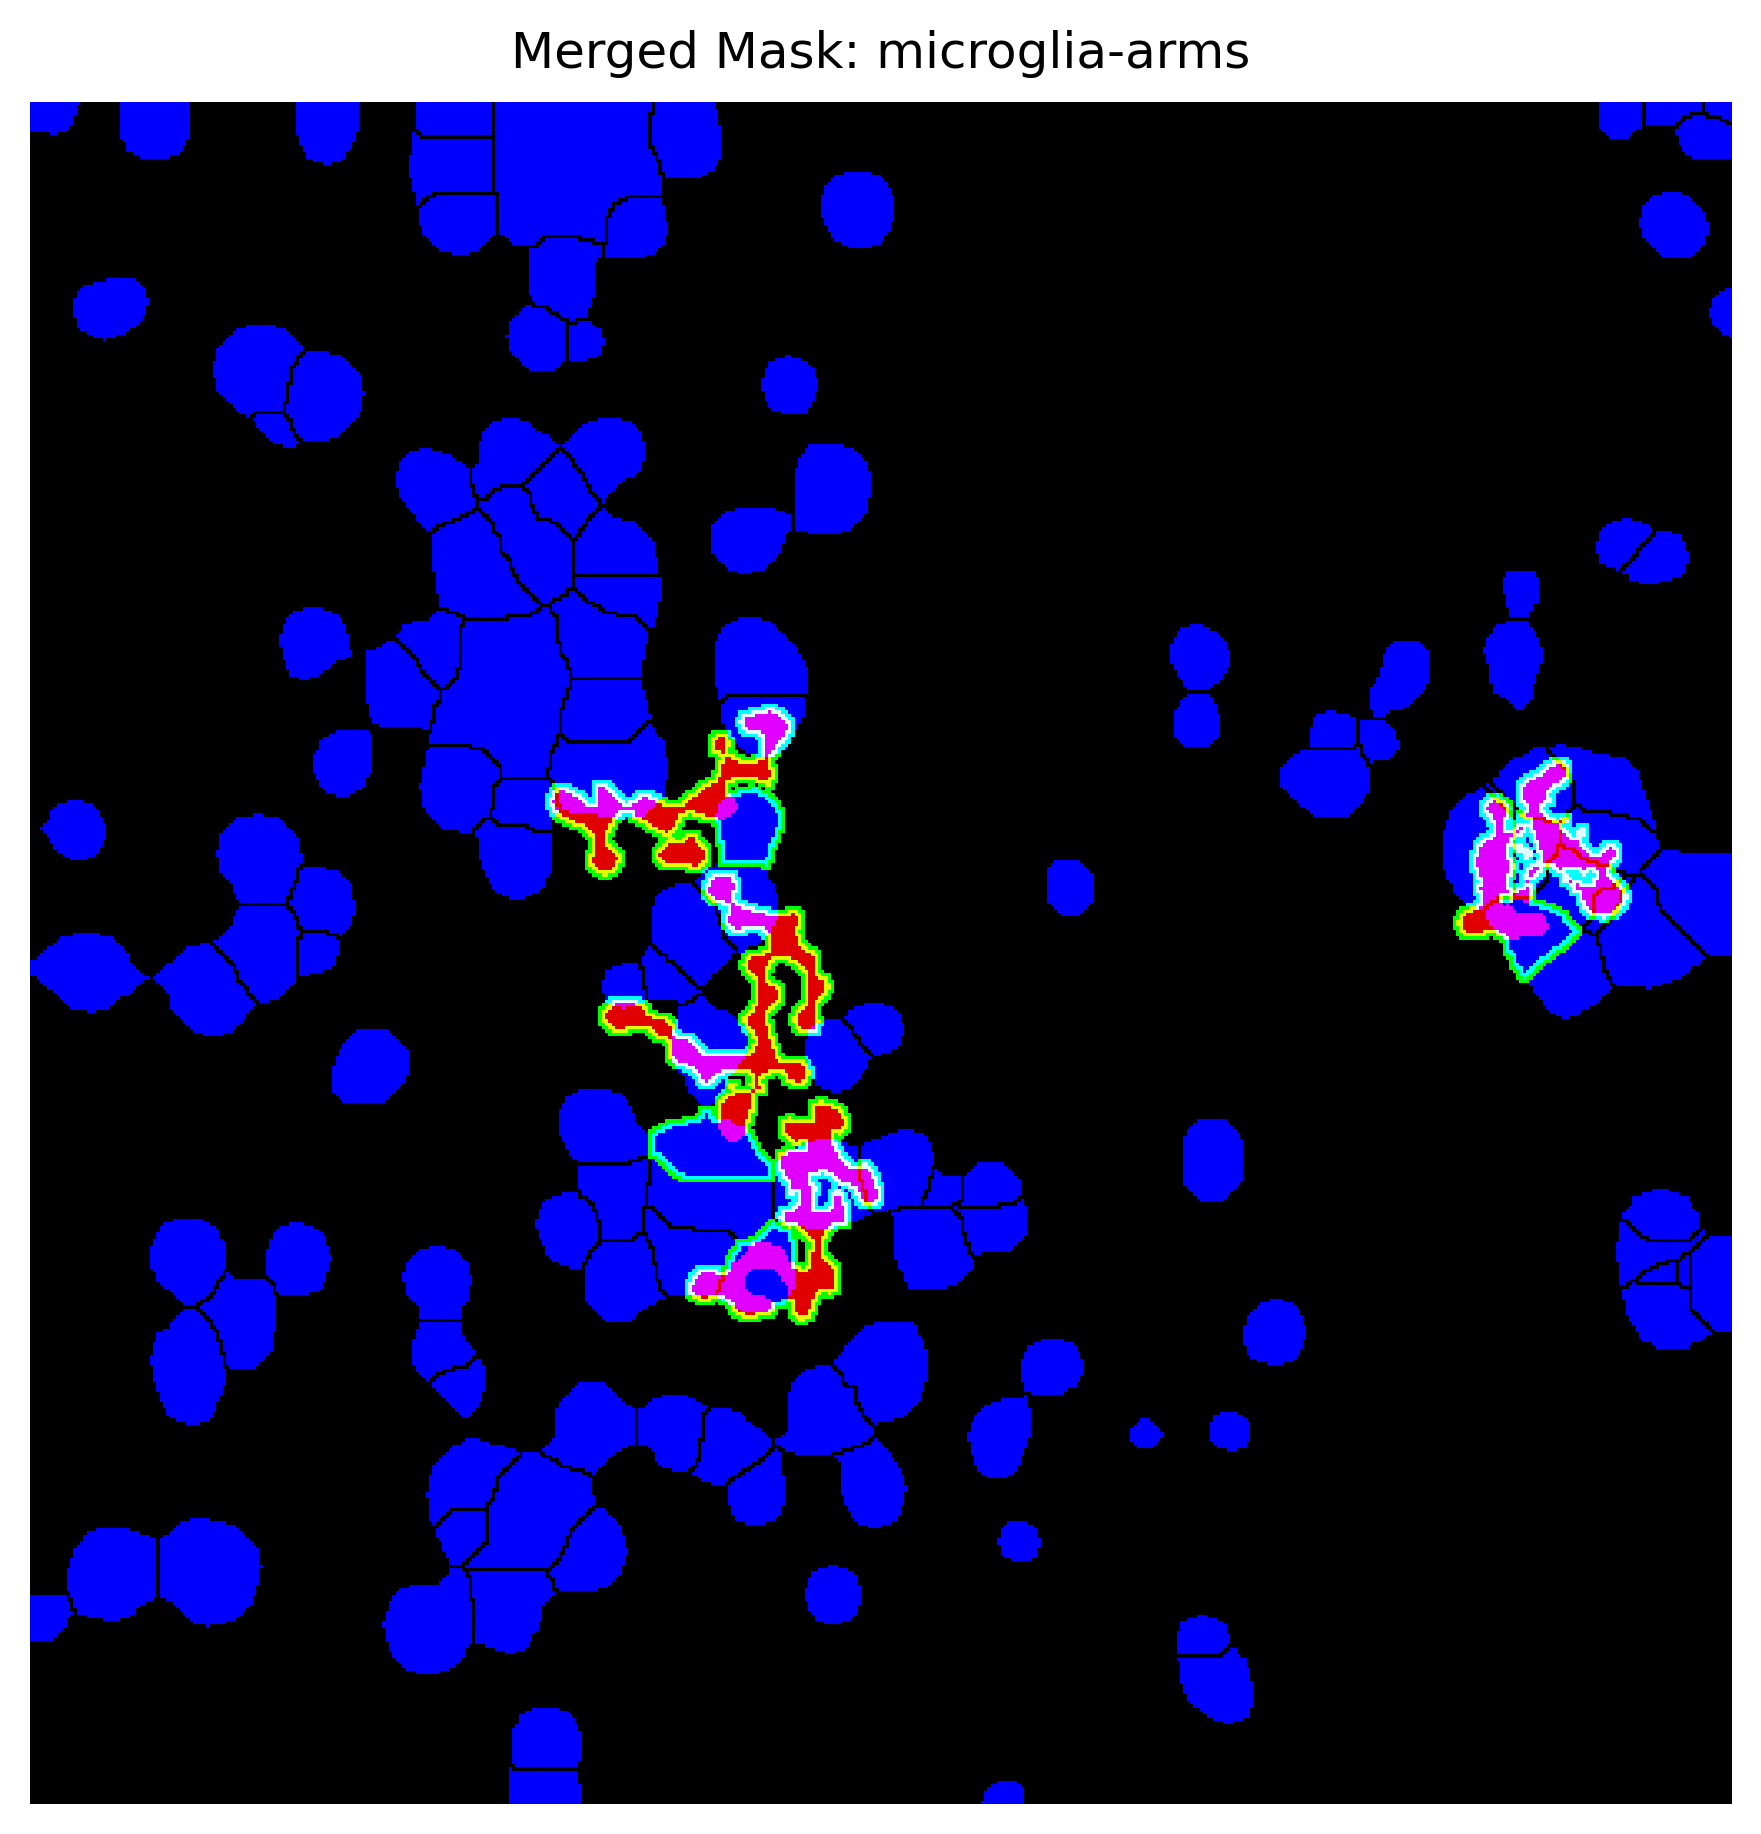

In [21]:
fov_name = "fov3"
merge_mask_view = "microglia-arms"
object_mask_dir = ez_masks_dir
cell_mask_dir = cell_dir
merged_mask_dir = merged_masks_dir

# Show test composite image
ez_seg_display.multiple_mask_display(fov_name, merge_mask_view, object_mask_dir, cell_mask_dir, merged_mask_dir)

## 6. Relabel all masks

Run this step to ensure all mask ids across all segmentations (deepcell, ez, or other inputs) are relabeled from 1 to n total masks.
Need to run before merging if applying merge step.

In [22]:
# Enter the root directory where all masks are located.
# May need to adjust this so masks and channel tiffs are both not imported by renumber masks.
root_mask_dir = merged_masks_dir

# Run this cell to relabel all masks in all folders.
ez_seg_utils.renumber_masks(root_mask_dir)

Relabeling Complete.


## 7. Generate single cell and/or object expression table

In [23]:
# set to True to bypass expensive cell or object property calculations
# only cell or object label, size, and centroid will be extracted if True
fast_extraction = False

# Override to give your cell label an alternative name (e.g. plaques.csv)
table_name = "cell_and_objects"

# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

**NOTE: if you're loading your own dataset, please make sure all the imaging data is in the same folder with each fov given its own folder and all fovs having the same channels.**

In [24]:
# combine any merged objects, any remaining unmerged cell-masks, and any remaining object masks which were not included.
(
    cell_table_size_normalized,
    cell_table_arcsinh_transformed,
) = marker_quantification.generate_cell_table(
    segmentation_dir=root_mask_dir,
    tiff_dir=image_data_dir,
    img_sub_folder=None,
    fovs=fovs,
    batch_size=5,
    nuclear_counts=nuclear_counts,
    fast_extraction=fast_extraction,
)

/Users/bryjc/Library/CloudStorage/GoogleDrive-bryjc@stanford.edu/My Drive/Software/ark-analysis/src/ark/segmentation/marker_quantification.py:291: UserWarning: No cells found in the following image: fov6
  warnings.warn("No cells found in the following image: {}".format(fov_name))


In [ ]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(
    os.path.join(cell_table_dir, table_name + "_table_size_normalized.csv"),
    compression=compression,
    index=False,
)
cell_table_arcsinh_transformed.to_csv(
    os.path.join(cell_table_dir, table_name + "_table_arcsinh_transformed.csv"),
    compression=compression,
    index=False,
)

If desired, save split CSV's based upon mask name

In [25]:
ez_seg_utils.filter_csvs_by_mask(csv_path_name=cell_table_dir, csv_substr_replace=table_name)

/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():


KeyboardInterrupt: 

## 8. (Optional) Create a Mantis-Viewer friendly set of masks.

If you would like your masks to be able to be viewed in mantis viewer, you can use the code below to create a file structure that will arrange the masks in a way they can easily be uploaded to the viewer.
NOTE: Only one mask can be viewed at a time in Mantis, so reloading the mask in the project options will be necessary.

In [ ]:
# mantis
fovs = io_utils.list_folders(image_data_dir)

# Change segmentation directory to merged_masks_dir if merging performed or just ez_mask_dir if no merging done.
ez_seg_utils.create_mantis_project(
    fovs=fovs,
    image_data_dir=image_data_dir,

    segmentation_dir=segmentation_dir,
    mantis_dir=ez_visualization_dir,
)